In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-08 01:32:50--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.1s    

2023-10-08 01:32:50 (14.1 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [3]:
df = pd.read_csv('data.csv')
columns = ['Make',
           'Model',
           'Year',
           'Engine HP',
           'Engine Cylinders',
           'Transmission Type',
           'Vehicle Style',
           'highway MPG',
           'city mpg']
target = df["MSRP"].apply(lambda x: 1 if x > df["MSRP"].mean() else 0)
df = df[columns]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df["above_average"] = target
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [4]:
numerical = [column for column in df.columns if df[column].dtype in ('int64', 'float64') and column != "above_average"]
print(numerical)
categorical = [column for column in df.columns if df[column].dtype == 'O' and column != "above_average"]
print(categorical)

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
['make', 'model', 'transmission_type', 'vehicle_style']


In [6]:
# split your data in train/val/test sets with 60%/20%/20% distribution

p1 = 0.6  # Training
p2 = 0.2  # Validation
p3 = 0.2  # Test

df_full_train, df_test = train_test_split(df, test_size=p3, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=p2 / (1 - p3), random_state=1)

print(len(df_train), len(df_val), len(df_test))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["above_average"].values
y_val = df_val["above_average"].values
y_test = df_test["above_average"].values

7148 2383 2383


### Question 1

In [10]:
for column in numerical:
    auc = roc_auc_score(y_train, df_train[column])
    if auc < 0.5:
        auc = 1 - auc
    print(column, auc)

year 0.687551492804683
engine_hp 0.9171031265539011
engine_cylinders 0.766116490165669
highway_mpg 0.6330587871772013
city_mpg 0.6734244643245233


### Question 2

In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.64241119, 0.01507493, 0.48520063, ..., 0.0052841 , 0.99998723,
       0.09606025])

In [16]:
round(roc_auc_score(y_val, y_pred), 3)

0.977

### Question 3

In [25]:
scores = []

thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [26]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

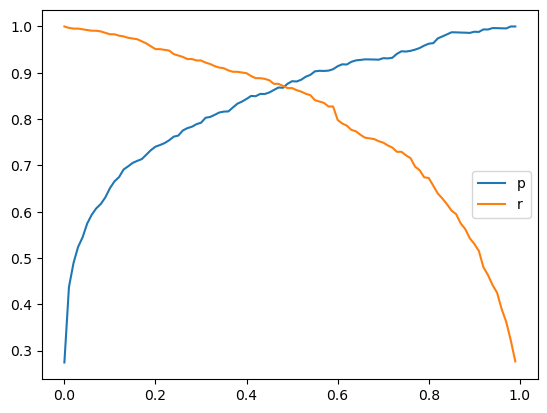

In [27]:
plt.plot(df_scores.threshold, df_scores['p'], label='p')
plt.plot(df_scores.threshold, df_scores['r'], label='r')
plt.legend();

In [23]:
# 0.48

### Question 4

In [28]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [31]:
max_index = list(df_scores['f1']).index(max(list(df_scores['f1'])))
thresholds[max_index]

0.5

### Question 5

In [45]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [46]:
C = 1

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +/- %.3f' % (np.mean(scores), np.std(scores)))



0.979 +/- 0.003


### Question 6

In [47]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.979 +- 0.001
C=10 0.981 +- 0.003


In [ ]:
# C = 10